# Monitoring & Evaluation — Churn Model

Este notebook demuestra:
- Cálculo de métricas (Accuracy, Precision/Recall, F1, ROC AUC)
- Detección de drift por **PSI**
- Reglas de alerta con umbrales configurables
- Simulación de **A/B test** y política de **rollback**

In [2]:

import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from pathlib import Path
from drift_utils import drift_report
from ab_test_sim import evaluate_ab, pick_winner

# Cargar dataset
data_path = Path('../01_pipeline_ml/data/clientes.csv')
df = pd.read_csv(data_path, parse_dates=['signup_date','last_purchase_date'])
df.head()


,customer_id,age,gender,signup_date,last_purchase_date,total_purchases,avg_purchase_value,is_active,churned
0,7602076e-427b-4c9e-bdec-181f9cf9a5ae,56,Male,2023-02-04,2025-04-01,4,251.00,1,0
1,95fda49f-1e60-4d2c-8f05-6db740f18a52,69,Female,2024-12-14,2025-07-10,8,155.37,1,0
2,ebfbf8a6-36cf-4678-bcdb-acce55a2d6ac,46,Female,2025-04-22,2025-03-26,2,299.25,1,0
3,c3a870d4-e33c-4640-a917-5d96e1ccb1fa,32,Female,2022-10-04,2024-11-29,4,233.66,0,0
4,38c4044e-4d7e-4a97-bc50-148fcc588566,60,Male,2023-01-03,2024-11-24,4,129.49,1,0


## 1) Entrenamiento rápido y métricas baseline

In [3]:

drop_cols = ["customer_id","signup_date","last_purchase_date","churned"]
features = [c for c in df.columns if c not in drop_cols]
X = pd.get_dummies(df[features], drop_first=True)
y = df["churned"].astype(int)

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
clf = LogisticRegression(max_iter=1000).fit(X_tr, y_tr)

proba = clf.predict_proba(X_te)[:,1]
pred = (proba>=0.5).astype(int)

baseline = {
    "accuracy": accuracy_score(y_te, pred),
    "precision": precision_score(y_te, pred),
    "recall": recall_score(y_te, pred),
    "f1": f1_score(y_te, pred),
    "roc_auc": roc_auc_score(y_te, proba)
}
baseline


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'accuracy': 0.696,
 'precision': 0.0,
 'recall': 0.0,
 'f1': 0.0,
 'roc_auc': 0.49776389046430736}

## 2) Simulación de batch actual + PSI (drift)

In [4]:

# Simular drift en numéricos
df_cur = df.copy()
num_cols = df_cur.select_dtypes(include=['int64','float64','int32','float32']).columns.tolist()
num_cols = [c for c in num_cols if c not in ['churned']]
np.random.seed(0)
for c in num_cols:
    df_cur[c] = df_cur[c] * (1 + 0.2*np.random.randn(len(df_cur)))

psi = drift_report(df[num_cols], df_cur[num_cols], features=num_cols)
psi


{'age': 0.06348075671324314,
 'total_purchases': 0.09251669238362899,
 'avg_purchase_value': 0.03434932629273072,
 'is_active': 3.596483784516973}

### Gráfico simple PSI por feature

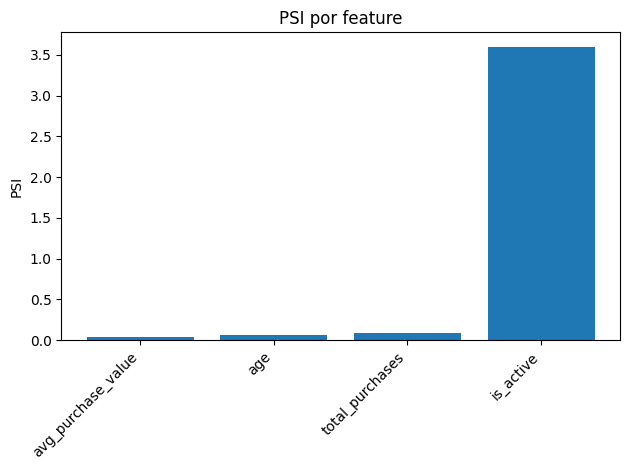

In [5]:

import matplotlib.pyplot as plt

items = sorted(psi.items(), key=lambda kv: kv[1] if kv[1] is not None else -1)
labels = [k for k,_ in items]
values = [v for _,v in items]

plt.figure()
plt.bar(labels, values)
plt.xticks(rotation=45, ha='right')
plt.title('PSI por feature')
plt.ylabel('PSI')
plt.tight_layout()
plt.show()


## 3) Reglas de alerta

In [6]:

AUC_MIN = 0.75
AUC_DROP_WARN = 0.05
PSI_WARN = 0.1
PSI_SEV = 0.25

alerts = []
if baseline['roc_auc'] < AUC_MIN:
    alerts.append(f"ROC AUC baseline {baseline['roc_auc']:.3f} < {AUC_MIN:.2f}")

sev = [k for k,v in psi.items() if v is not None and v>PSI_SEV]
mod = [k for k,v in psi.items() if v is not None and PSI_WARN<=v<=PSI_SEV]
if sev: alerts.append('PSI severo en: ' + ', '.join(sev))
if mod: alerts.append('PSI moderado en: ' + ', '.join(mod))
alerts


['ROC AUC baseline 0.498 < 0.75', 'PSI severo en: is_active']

## 4) A/B Test (simulación)

In [7]:

# Crear dos variantes simuladas a partir de proba con ligeras perturbaciones
rng = np.random.RandomState(42)
y_true = y_te.values
y_proba_v1 = np.clip(proba + rng.normal(0, 0.02, size=len(proba)), 0, 1)
y_pred_v1 = (y_proba_v1>=0.5).astype(int)

y_proba_v2 = np.clip(proba + rng.normal(0.01, 0.02, size=len(proba)), 0, 1)
y_pred_v2 = (y_proba_v2>=0.5).astype(int)

import pandas as pd
df_ab = pd.DataFrame({
    'y_true': y_true,
    'y_proba_v1': y_proba_v1,
    'y_pred_v1': y_pred_v1,
    'y_proba_v2': y_proba_v2,
    'y_pred_v2': y_pred_v2,
})

res = evaluate_ab(df_ab)
winner = pick_winner(res, primary='roc_auc', secondary='f1')
res, winner


({'v1': {'accuracy': 0.696, 'f1': 0.0, 'roc_auc': 0.48390710072595283},
  'v2': {'accuracy': 0.696, 'f1': 0.0, 'roc_auc': 0.5206927272383546}},
 'v2')

## 5) Política de Rollback
- Si hay **PSI severo** en ≥2 features o **AUC** cae ≥10% vs. baseline → **Rollback a versión previa**.
- En Vertex AI: ajustar **traffic split** del Endpoint al modelo anterior mientras se reentrena.